In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)    # resize plots

from scipy import stats

from blueice.source import Source
from blueice.model import Model
from blueice.inference import plot_likelihood_ratio, bestfit_scipy

In [2]:
class GaussianSource(Source):
    fraction_in_range = 1

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.events_per_day *= self.model.config['some_multiplier']
        (self.mu, self.sigma) = (self.model.config['mu'], self.model.config['sigma'])

    def pdf(self, *args):
        return stats.norm(self.mu, self.sigma).pdf(args[0])
        
    def simulate(self, n_events):
        d = np.zeros(n_events, dtype=[('x',np.float),('source',np.int)])
        d['x']= stats.norm(self.mu, self.sigma).rvs(n_events)
        
        return d

the_bins = np.linspace(-10, 10, 100)
config = dict(
    sources = [{'class': GaussianSource,
                'name': 'foo',
                'events_per_day':  int(1e3)}],
    mu = 0,
    sigma = 1,
    some_multiplier = 1,
    force_pdf_recalculation=True,
    analysis_space=[['x', the_bins]]
)

In [3]:
m = Model(config)
m.expected_events()

array([1000])

In [4]:
from blueice.likelihood import LogLikelihood
lf = LogLikelihood(config)
lf.add_shape_parameter('some_multiplier', (0.5, 1, 2))
lf.add_rate_parameter('foo')
lf.prepare()
d = lf.base_model.simulate()
print(len(d), lf.base_model.expected_events())
lf.set_data(d)

999 [1000]


In [5]:
for k, m in lf.anchor_models.items():
    print(k, m.expected_events(), m.sources[0].events_per_day, m.sources[0].fraction_in_range)

(0.5,) [ 500.] 500.0 1
(1.0,) [1000] 1000 1
(2.0,) [2000] 2000 1


(0.5, 2)

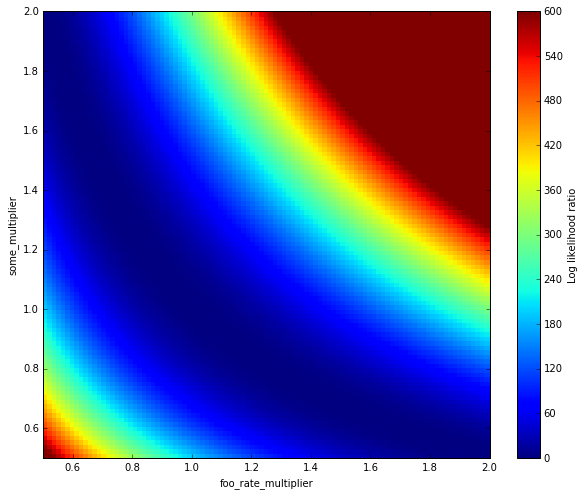

In [6]:
x = np.linspace(0.5, 2, 100)
plot_likelihood_ratio(lf, ('foo_rate_multiplier', x), ('some_multiplier', x), vmax=600)
plt.xlim(0.5, 2)
plt.ylim(0.5, 2)

(-1, 5)

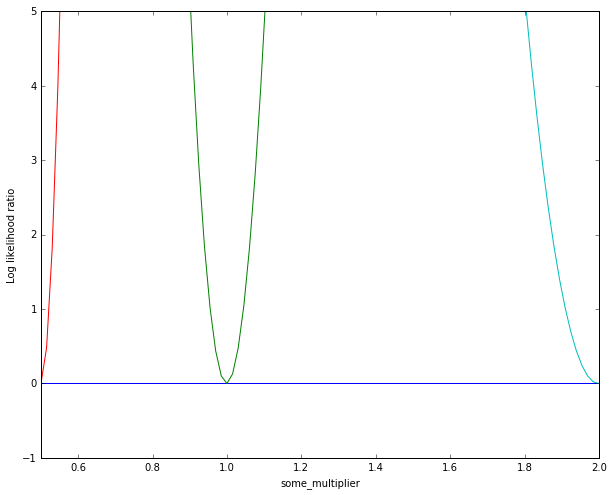

In [7]:
# Should be flat 0 (since fitting foo_rate_multiplier completely compensates for some_multiplier)
plot_likelihood_ratio(lf, ('some_multiplier', x))

# Should be centered at 1:
plot_likelihood_ratio(lf, ('some_multiplier', x), foo_rate_multiplier=1)

# Should be centered at 0.5:
plot_likelihood_ratio(lf, ('some_multiplier', x), foo_rate_multiplier=2)

# Should be centered at 2
plot_likelihood_ratio(lf, ('some_multiplier', x), foo_rate_multiplier=0.5)
plt.ylim(-1, 5)

(-1, 5)

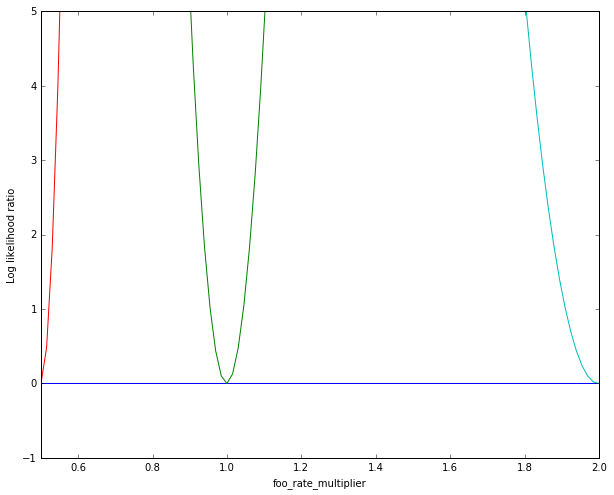

In [8]:
# Should be flat 0. However, unlike the rate multiplier, the shape parameter is bounded by the anchors we put in
# Try changing pass_bounds_to_minimizer to True in blueice.inference, and it will become a complete mess below 1!
plot_likelihood_ratio(lf, ('foo_rate_multiplier', x))

# Should be centered at 1
plot_likelihood_ratio(lf, ('foo_rate_multiplier', x), some_multiplier=1)

# Should be centered at 0.5
plot_likelihood_ratio(lf, ('foo_rate_multiplier', x), some_multiplier=2)

# Should be centered at 2:
plot_likelihood_ratio(lf, ('foo_rate_multiplier', x), some_multiplier=0.5)
plt.xlim(0.5, 2)
plt.ylim(-1, 5)

Why does the blue line start following the red linear near 0.5??

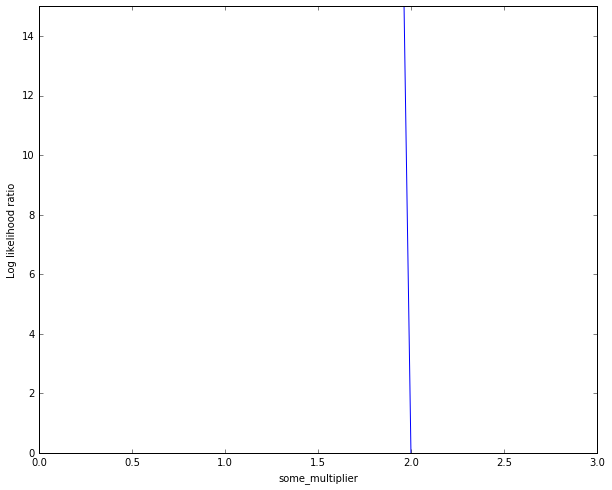

In [9]:
# Will be centered at 2, and very steep. 
# It would like to go to 10, but can't because of the bounds on the shape param
plot_likelihood_ratio(lf, ('some_multiplier', np.linspace(0, 3, 100)), foo_rate_multiplier=0.1)

# More rate-shape parameter checks

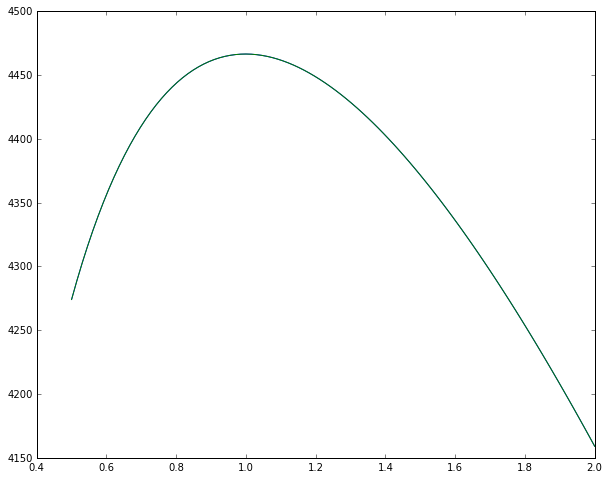

In [10]:
# Should be exactly the same:
plt.plot(x, [lf(some_multiplier=q) for q in x])
plt.plot(x, [lf(foo_rate_multiplier=q) for q in x])

In [11]:
from blueice.inference import make_objective
w1 = make_objective(lf, some_multiplier=0.6)
w2 = make_objective(lf, foo_rate_multiplier=0.6)
print(w1, "\n", w2)
f1 = w1[0]
f2 = w2[0]

(<function make_objective.<locals>.objective at 0x7f3729f5fbf8>, ['foo_rate_multiplier'], array([1]), [(0, None)]) 
 (<function make_objective.<locals>.objective at 0x7f3729f5fb70>, ['some_multiplier'], array([1]), [(0.5, 2)])


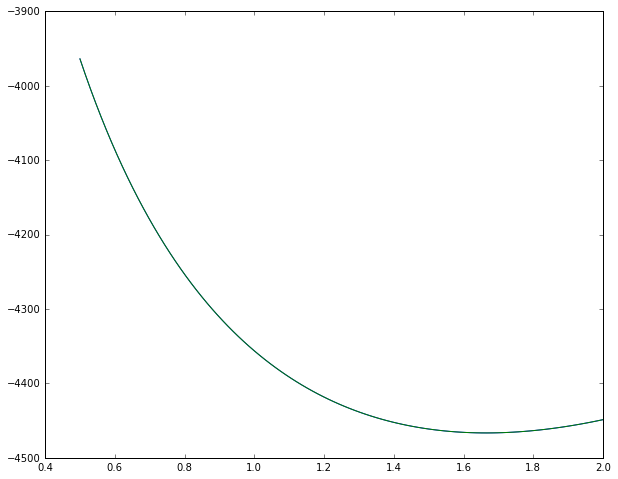

In [12]:
# Should be exactly the same
plt.plot(x, [f1([q]) for q in x])
plt.plot(x, [f2([q]) for q in x])

In [13]:
q = 0.6
kwargs = dict()
a = bestfit_scipy(lf, some_multiplier=q, **kwargs)[0]
b = bestfit_scipy(lf, foo_rate_multiplier=q, **kwargs)[0]
print(a, b, len(d)/lf.base_model.expected_events()/q)

{'foo_rate_multiplier': 1.6649999616312248} {'some_multiplier': 1.6650000620710228} [ 1.665]
